In [73]:

#@title Install & import (safe to re-run)
import sys, subprocess

def pip_install(pkg):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg], check=False)

pip_install("gdown>=5.1")
pip_install("pandas>=1.5")
pip_install("numpy>=1.23")
pip_install("matplotlib>=3.7")
pip_install("scikit-learn>=1.3")

import gdown, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#package.module


In [74]:
import gdown, os, pandas as pd

# GDOWN_ID = "1VXJ0VcTBUsdbKs9FBNYMUP7gnemZ7W1q"  # replace with your file’s ID
OUTPUT_CSV = "/content/house_price_regression_dataset.csv"

# if not os.path.exists(OUTPUT_CSV):
#     url = f"https://drive.google.com/uc?id={GDOWN_ID}"
#     gdown.download(url, OUTPUT_CSV, quiet=False)
# else:
#     print("Found existing file:", OUTPUT_CSV)

df = pd.read_csv(OUTPUT_CSV)
print("✅ Loaded:", df.shape)
display(df.head())

✅ Loaded: (1000, 8)


,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
0,1360,2,1,1981,0.599637,0,5,2.623829e+05
1,4272,3,3,2016,4.753014,1,6,9.852609e+05
2,3592,1,2,2016,3.634823,0,9,7.779774e+05
3,966,1,2,1977,2.730667,1,8,2.296989e+05
4,4926,2,1,1993,4.699073,0,8,1.041741e+06


In [75]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder

# 1) Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print("✅ Standardized column names:", list(df.columns))

# 2) Check duplicates
print("Duplicates count:", df.duplicated().sum())
df = df.drop_duplicates()

# 3) Columns with missing values
print("Missing values per column:")
print(df.isnull().sum())

# 4) Numeric imputation strategy (example: mean)
num_cols = df.select_dtypes(include=np.number).columns
print("Numeric columns:", list(num_cols))

num_imputer = SimpleImputer(strategy="mean")   # or "median"
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# 5) Categorical imputation (most_frequent) - Removed as there are no categorical columns
# cat_cols = df.select_dtypes(exclude=np.number).columns
# print("Categorical columns:", list(cat_cols))

# cat_imputer = SimpleImputer(strategy="most_frequent")
# df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# 6) Encoding strategy (One Hot Encoding) - Not needed as there are no categorical columns
# df = pd.get_dummies(df, drop_first=True)

# 7) Scaling strategy (StandardScaler or MinMax)
scaler = StandardScaler()
numeric_cols_after_dummy = df.select_dtypes(include=np.number).columns.tolist()
# Exclude the target variable from scaling if it's numeric
if 'house_price' in numeric_cols_after_dummy:
    numeric_cols_after_dummy.remove('house_price')
df[numeric_cols_after_dummy] = scaler.fit_transform(df[numeric_cols_after_dummy])


# 8) Outlier handling (IQR method example)
# Re-identify numeric columns after one-hot encoding
numeric_cols_after_dummy = df.select_dtypes(include=np.number).columns.tolist()
if 'house_price' in numeric_cols_after_dummy:
    numeric_cols_after_dummy.remove('house_price')

for col in numeric_cols_after_dummy:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"Outliers in {col}: {len(outliers)}")

# 9) Feature selection/dropping (example: drop writing_score if highly correlated with reading_score)
# You can check correlations first
corr = df.corr(numeric_only=True)
print(corr["house_price"].sort_values(ascending=False))

✅ Standardized column names: ['square_footage', 'num_bedrooms', 'num_bathrooms', 'year_built', 'lot_size', 'garage_size', 'neighborhood_quality', 'house_price']
Duplicates count: 0
Missing values per column:
square_footage          0
num_bedrooms            0
num_bathrooms           0
year_built              0
lot_size                0
garage_size             0
neighborhood_quality    0
house_price             0
dtype: int64
Numeric columns: ['square_footage', 'num_bedrooms', 'num_bathrooms', 'year_built', 'lot_size', 'garage_size', 'neighborhood_quality', 'house_price']
Outliers in square_footage: 0
Outliers in num_bedrooms: 0
Outliers in num_bathrooms: 0
Outliers in year_built: 0
Outliers in lot_size: 0
Outliers in garage_size: 0
Outliers in neighborhood_quality: 0
house_price             1.000000
square_footage          0.991261
lot_size                0.160412
garage_size             0.052133
year_built              0.051967
num_bedrooms            0.014633
num_bathrooms          -

house_price             1.000000
square_footage          0.991261
lot_size                0.160412
garage_size             0.052133
year_built              0.051967
num_bedrooms            0.014633
num_bathrooms          -0.001862
neighborhood_quality   -0.007770
Name: house_price, dtype: float64


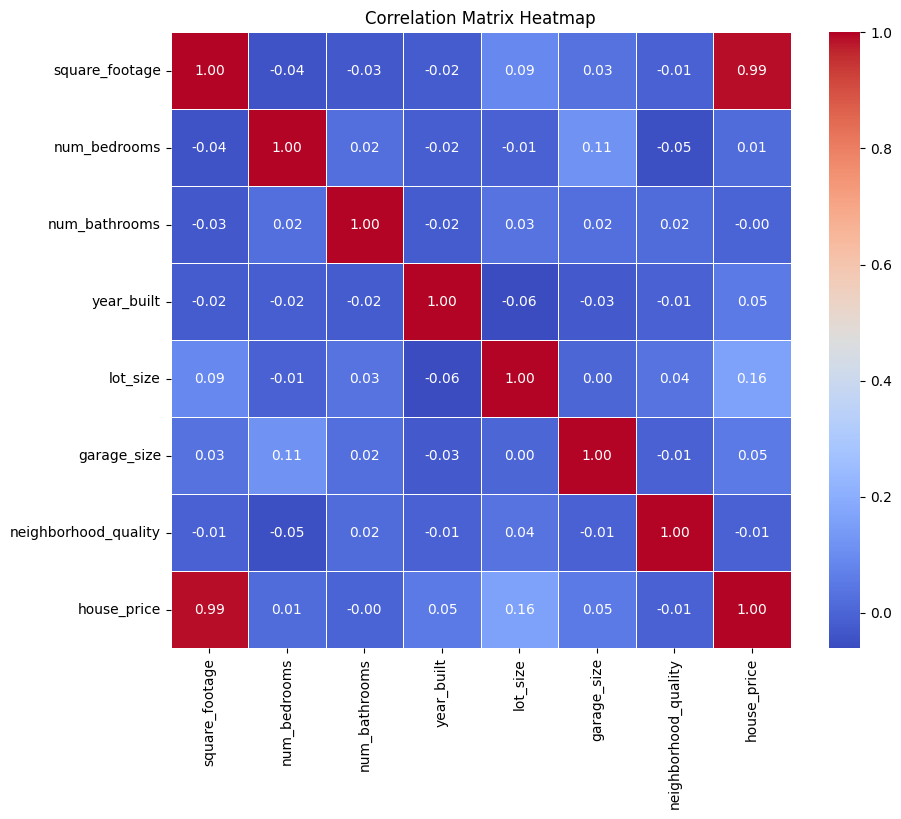

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr(numeric_only=True)
print(corr['house_price'].sort_values(ascending=False))

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

X = df.drop(columns=['house_price'])
y = df['house_price']

# one-hot encode categorical features
# X = pd.get_dummies(X, drop_first=True) # No categorical features in this dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2_test = r2_score(y_test, y_pred)
r2_train = model.score(X_train, y_train)
gap = abs(r2_train - r2_test)
print(mae, mse, rmse, r2_test, r2_train,gap)

8174.583600006623 101434798.50563595 10071.484424137087 0.9984263636823413 0.9985375946918145 0.00011123100947318942


In [78]:
import statsmodels.api as sm

# Select only numeric columns from the dataframe
X_vif = df.select_dtypes(include=np.number).drop(columns=['house_price'])

# Add constant
X_vif = sm.add_constant(X_vif)

print(X_vif.dtypes)

const                   float64
square_footage          float64
num_bedrooms            float64
num_bathrooms           float64
year_built              float64
lot_size                float64
garage_size             float64
neighborhood_quality    float64
dtype: object


In [79]:
import statsmodels.api as sm

# Select only numeric columns from the dataframe
X_vif = df.select_dtypes(include=np.number).drop(columns=['house_price'])

# Add constant again
X_vif = sm.add_constant(X_vif)

In [80]:
print(X_vif.dtypes)   # should all be int64 or float64

const                   float64
square_footage          float64
num_bedrooms            float64
num_bathrooms           float64
year_built              float64
lot_size                float64
garage_size             float64
neighborhood_quality    float64
dtype: object


In [81]:
# Convert all bool columns to int (0/1) - Not needed as there are no boolean columns
X_vif = X_vif.astype(float)   # make sure all are float for statsmodels

In [82]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Ensure all features are numeric
X_vif = X_vif.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
X_vif = X_vif.astype(float)  # make sure all are float for statsmodels

# Compute VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]
print(vif_data.sort_values(by="VIF", ascending=False))

                feature       VIF
2          num_bedrooms  1.018403
6           garage_size  1.015530
5              lot_size  1.014446
1        square_footage  1.012926
4            year_built  1.005280
7  neighborhood_quality  1.004384
3         num_bathrooms  1.004108
0                 const  1.000000


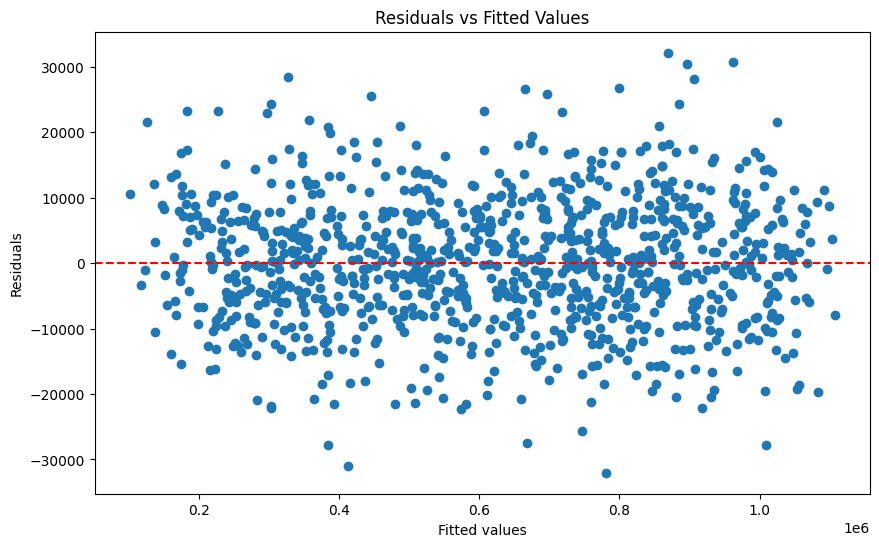

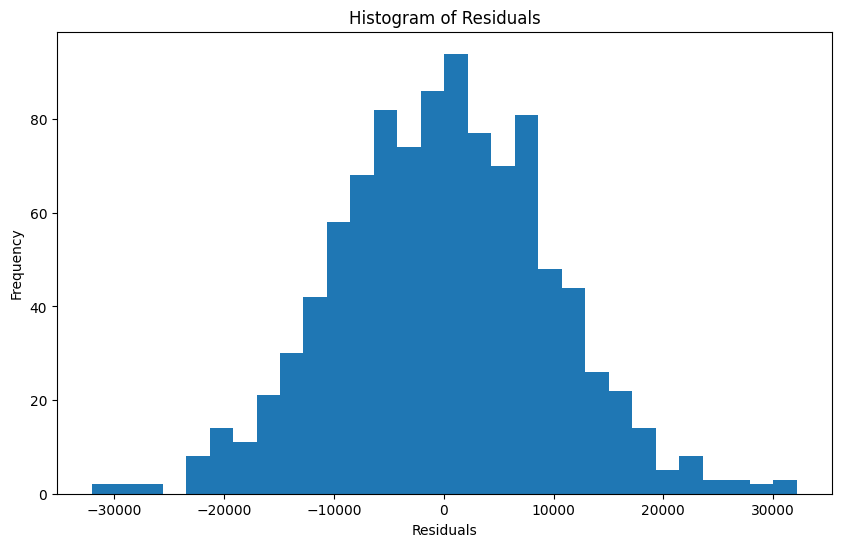

In [95]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# X_vif is your features after get_dummies and adding constant
model = sm.OLS(df['house_price'], X_vif).fit()
residuals = model.resid  # differences between predicted and actual values

# Plotting residuals vs fitted values
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Plotting a histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [84]:
from scipy.stats import shapiro
shapiro_test = shapiro(residuals)
shapiro_p = shapiro_test[1]  # this is what goes in your table
print("Shapiro p-value:", shapiro_p)

Shapiro p-value: 0.6177613996976226


In [85]:
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(residuals)
print("Durbin-Watson:", dw)

Durbin-Watson: 2.0666573671553894


In [86]:
import statsmodels.stats.api as sms
bp_test = sms.het_breuschpagan(residuals, model.model.exog)
bp_p = bp_test[1]
print("Breusch-Pagan p-value:", bp_p)

Breusch-Pagan p-value: 0.5560655968188333


In [87]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

X = df[['square_footage']]  # example feature
y = df['house_price']

best_r2 = -np.inf
best_deg = 1
for deg in [1,2,3]:
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    X_poly = poly.fit_transform(X)
    r2 = cross_val_score(LinearRegression(), X_poly, y, cv=5, scoring='r2').mean()
    if r2 > best_r2:
        best_r2 = r2
        best_deg = deg

print("Best degree:", best_deg, "CV R²:", best_r2)

Best degree: 1 CV R²: 0.9825165612767173


In [88]:
cat_cols = df.select_dtypes(include=['object']).columns
print(cat_cols)

Index([], dtype='object')


In [89]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Target
y = df['house_price']

# Features (all columns except the target)
X = df.drop(columns=['house_price'])
import numpy as np
X_enc = X.astype(float)

In [90]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# X before encoding (only numeric columns)
X_num = df.select_dtypes(include=np.number).drop(columns=['house_price'])
y = df['house_price']

model = LinearRegression()
r2_before = cross_val_score(model, X_num, y, cv=5, scoring='r2').mean()
print("R² before encoding:", r2_before)

R² before encoding: 0.9984911165291178


In [91]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# X_enc is already the numeric features
# y is the target variable

model = LinearRegression()
r2_after = cross_val_score(model, X_enc, y, cv=5, scoring='r2').mean()
print("R² after (no) encoding:", r2_after)

R² after (no) encoding: 0.9984911165291178


In [92]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=42)

lasso = Lasso(max_iter=10000)
alphas = [0.01, 0.1, 1, 10]
grid = GridSearchCV(lasso, param_grid={'alpha': alphas}, cv=5, scoring='r2')
grid.fit(X_train, y_train)

best_alpha = grid.best_params_['alpha']
best_r2 = grid.best_score_
test_r2 = grid.score(X_test, y_test)
non_zero = np.sum(grid.best_estimator_.coef_ != 0)

print("Best alpha:", best_alpha)
print("CV R²:", best_r2)
print("Test R²:", test_r2)
print("# non-zero coefs:", non_zero)

Best alpha: 10
CV R²: 0.9985166393546502
Test R²: 0.998426095873396
# non-zero coefs: 7


In [93]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=42)

# Alpha values to try
alpha_grid = [0.01, 0.1, 1, 10]

# ----- Lasso -----
lasso = Lasso(max_iter=10000)
grid_lasso = GridSearchCV(lasso, param_grid={'alpha': alpha_grid}, cv=5, scoring='r2')
grid_lasso.fit(X_train, y_train)

# Values for table
lasso_best_alpha = grid_lasso.best_params_['alpha']
lasso_r2_test = grid_lasso.score(X_test, y_test)
lasso_nonzero = np.sum(grid_lasso.best_estimator_.coef_ != 0)

print("Lasso:")
print("Alpha grid:", alpha_grid)
print("Best alpha:", lasso_best_alpha)
print("Test R²:", lasso_r2_test)
print("# Non-zero coefficients:", lasso_nonzero)

# ----- Ridge -----
ridge = Ridge(max_iter=10000)
grid_ridge = GridSearchCV(ridge, param_grid={'alpha': alpha_grid}, cv=5, scoring='r2')
grid_ridge.fit(X_train, y_train)

ridge_best_alpha = grid_ridge.best_params_['alpha']
ridge_r2_test = grid_ridge.score(X_test, y_test)

print("\nRidge:")
print("Alpha grid:", alpha_grid)
print("Best alpha:", ridge_best_alpha)
print("Test R²:", ridge_r2_test)
# Ridge keeps all coefficients non-zero
print("# Non-zero coefficients: all")

Lasso:
Alpha grid: [0.01, 0.1, 1, 10]
Best alpha: 10
Test R²: 0.998426095873396
# Non-zero coefficients: 7

Ridge:
Alpha grid: [0.01, 0.1, 1, 10]
Best alpha: 0.01
Test R²: 0.99842621644065
# Non-zero coefficients: all


In [94]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
import numpy as np

cv_folds = 5
model = LinearRegression()

# R² CV scores
r2_scores = cross_val_score(model, X_enc, y, cv=cv_folds, scoring='r2')
r2_mean = r2_scores.mean()
r2_std = r2_scores.std()

# RMSE CV
y_pred = cross_val_predict(model, X_enc, y, cv=cv_folds)
rmse = np.sqrt(mean_squared_error(y, y_pred))

# RMSE CV std can be approximated per fold
from sklearn.model_selection import KFold

kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
rmse_per_fold = []
for train_idx, test_idx in kf.split(X_enc):
    model.fit(X_enc.iloc[train_idx], y.iloc[train_idx])
    y_pred_fold = model.predict(X_enc.iloc[test_idx])
    rmse_fold = np.sqrt(mean_squared_error(y.iloc[test_idx], y_pred_fold))
    rmse_per_fold.append(rmse_fold)

rmse_mean = np.mean(rmse_per_fold)
rmse_std = np.std(rmse_per_fold)

print("R² CV mean:", r2_mean)
print("R² CV std:", r2_std)
print("RMSE CV mean:", rmse_mean)
print("RMSE CV std:", rmse_std)

R² CV mean: 0.9984911165291178
R² CV std: 3.062328772022318e-05
RMSE CV mean: 9812.20032235335
RMSE CV std: 331.7354199378566
